In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Goal: To use data analytics to determine the MVP of each season of NBA basketball played since 2000.

#### We hope to remove media biases and narritives and simply present the player that statistically added the most value to their team each year.

In [12]:
player_stats = pd.read_csv("/Users/sa12/Documents/Repositories/nba-stats/data/player_stats/merge2000-2024.csv").drop_duplicates()
adv_player_stats = pd.read_csv("/Users/sa12/Documents/Repositories/nba-stats/data/advanced_stats/merge2000-2024.csv").drop_duplicates()
mvps = pd.read_csv("/Users/sa12/Documents/Repositories/nba-stats/data/MVPs.csv").drop_duplicates()
team_stats = pd.read_csv("/Users/sa12/Documents/Repositories/nba-stats/data/team_stats/merge2000-2024.csv").drop_duplicates()

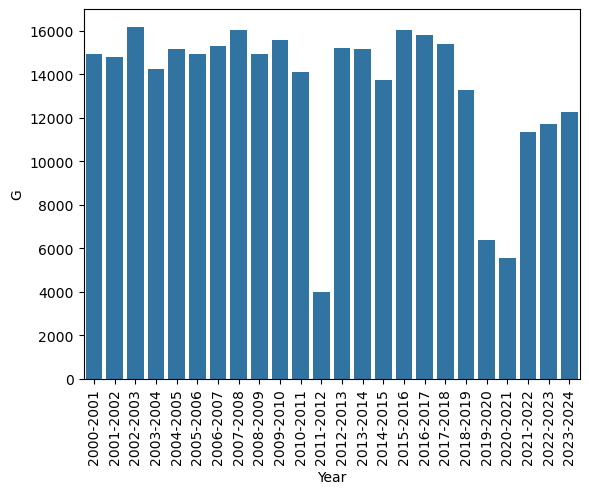

In [13]:
#In 2022, the NBA introduced a rule mandating that players play 65 games to be eligible for end of season awards.
#I am going to apply this criteria to historical data to see if it changes anything

#First line of code removes rows double-counting player's stats who were traded mid-season
player_stats = player_stats[player_stats["Team"].str.contains("2TM") == False]
eligible_players = player_stats[player_stats["G"] >= 65]
adv_player_stats = adv_player_stats[adv_player_stats["Team"].str.contains("2TM") == False]
adv_eligible_players = adv_player_stats[adv_player_stats["G"] >= 65]
games_played = eligible_players.groupby(eligible_players["Year"])["G"].sum()
sns.barplot(games_played)
plt.xticks(rotation=90)
plt.show()

We notice a sharp decline in the 2011-2012 season. Research shows this was due to only playing 66 games due to a lockout. Future analysis must account this.

We also begin to see a downward trend in 2019-2021. This is likely due to covid restrictions. However, even after restrictions were lifted, number of games played over 65 is signifcantly lower than previously.

In [14]:
#seperating combined dataframe into uniquiely defined seasons
eligible_2000_2001 = eligible_players[eligible_players["Year"] == "2000-2001"]
adv_eligible_2000_2001 = adv_eligible_players[adv_eligible_players["Year"] == "2000-2001"]
eligible_2001_2002 = eligible_players[eligible_players["Year"] == "2001-2002"]
adv_eligible_2001_2002 = adv_eligible_players[adv_eligible_players["Year"] == "2001-2002"]
eligible_2002_2003 = eligible_players[eligible_players["Year"] == "2002-2003"]
adv_eligible_2002_2003 = adv_eligible_players[adv_eligible_players["Year"] == "2002-2003"]
eligible_2003_2004 = eligible_players[eligible_players["Year"] == "2003-2004"]
adv_eligible_2003_2004 = adv_eligible_players[adv_eligible_players["Year"] == "2003-2004"]
eligible_2004_2005 = eligible_players[eligible_players["Year"] == "2004-2005"]
eligible_2005_2006 = eligible_players[eligible_players["Year"] == "2005-2006"]
eligible_2006_2007 = eligible_players[eligible_players["Year"] == "2006-2007"]
eligible_2007_2008 = eligible_players[eligible_players["Year"] == "2007-2008"]
eligible_2008_2009 = eligible_players[eligible_players["Year"] == "2008-2009"]
eligible_2009_2010 = eligible_players[eligible_players["Year"] == "2009-2010"]
eligible_2010_2011 = eligible_players[eligible_players["Year"] == "2010-2011"]
eligible_2011_2012 = eligible_players[eligible_players["Year"] == "2011-2012"]
eligible_2012_2013 = eligible_players[eligible_players["Year"] == "2012-2013"]
eligible_2013_2014 = eligible_players[eligible_players["Year"] == "2013-2014"]
eligible_2014_2015 = eligible_players[eligible_players["Year"] == "2014-2015"]
eligible_2015_2016 = eligible_players[eligible_players["Year"] == "2015-2016"]
eligible_2016_2017 = eligible_players[eligible_players["Year"] == "2016-2017"]
eligible_2017_2018 = eligible_players[eligible_players["Year"] == "2017-2018"]
eligible_2018_2019 = eligible_players[eligible_players["Year"] == "2018-2019"]
eligible_2019_2020 = eligible_players[eligible_players["Year"] == "2019-2020"]
eligible_2020_2021 = eligible_players[eligible_players["Year"] == "2020-2021"]
eligible_2021_2022 = eligible_players[eligible_players["Year"] == "2021-2022"]
eligible_2022_2023 = eligible_players[eligible_players["Year"] == "2022-2023"]
eligible_2023_2024 = eligible_players[eligible_players["Year"] == "2023-2024"]

In [15]:
adv_eligible_2003_2004

,Year,Player,Age,Team,Pos,G,GS,MP,PER,TS%,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Awards,Player-additional,
15392,2003-2004,Joe Johnson,22.0,PHO,SG,82.0,77.0,3331.0,13.9,0.491,...,1.1,3.3,0.047,0.1,-1.4,-1.3,0.6,NaN,johnsjo02,NaN
15393,2003-2004,Peja Stojaković,26.0,SAC,SF,81.0,81.0,3264.0,21.8,0.624,...,2.1,13.5,0.198,5.2,-1.3,3.9,4.9,MVP-4ASNBA2,stojape01,NaN
15397,2003-2004,Kevin Garnett,27.0,MIN,PF,82.0,82.0,3231.0,29.4,0.547,...,8.0,18.3,0.272,6.8,3.3,10.2,10.0,MVP-1DPOY-6ASNBA1,garneke01,NaN
15398,2003-2004,Cuttino Mobley,28.0,HOU,SG,80.0,80.0,3229.0,14.1,0.535,...,4.3,7.6,0.114,0.5,0.9,1.4,2.8,NaN,moblecu01,NaN
15399,2003-2004,Shawn Marion,25.0,PHO,SF,79.0,79.0,3217.0,19.9,0.513,...,3.8,9.1,0.135,3.0,0.6,3.6,4.6,NaN,mariosh01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15714,2003-2004,Brian Scalabrine,25.0,NJN,PF,69.0,2.0,928.0,9.5,0.482,...,1.4,1.7,0.089,-3.2,0.7,-2.6,-0.1,NaN,scalabr01,NaN
15721,2003-2004,Elden Campbell,35.0,DET,C,65.0,27.0,892.0,13.8,0.490,...,2.0,2.1,0.115,-3.0,2.0,-1.0,0.2,NaN,campbel01,NaN
15722,2003-2004,Kyle Korver,22.0,PHI,SF,74.0,0.0,882.0,10.1,0.489,...,0.8,1.0,0.054,-0.2,-0.5,-0.7,0.3,NaN,korveky01,NaN
15751,2003-2004,Shawn Bradley,31.0,DAL,C,66.0,5.0,773.0,15.6,0.523,...,0.9,2.3,0.145,-1.5,1.6,0.1,0.4,NaN,bradlsh01,NaN


In [16]:
raw_value_2000_2001 = pd.DataFrame(eligible_2000_2001["Player"])
#dataframe of eligible players in the season
#create an aggregate number based on the sum of traditional counting stats subtracted by the sum of traditional negative stats
raw_value_2000_2001["Raw Score"] = eligible_2000_2001["PTS"] + eligible_2000_2001["AST"] + eligible_2000_2001["TRB"] + eligible_2000_2001["BLK"] + eligible_2000_2001["STL"] - eligible_2000_2001["PF"] - eligible_2000_2001["TOV"]
#Raw Value = Points + Assists + Rebounds + Blocks + Steals - Fouls - Turnovers
raw_value_2000_2001["eFG%"] = eligible_2000_2001["eFG%"]
#Added a column with Effective Field Goal % to give an idea of effiency in scoring points, the largest portion of our raw score.
raw_value_2000_2001 = raw_value_2000_2001.set_index("Player")
#Setting the index to lock players to the values, than sorting in decending order
raw_value_2000_2001 = raw_value_2000_2001.sort_values("Raw Score", ascending=False)
#Now we can view our top 10 players in "Raw Value"
raw_value_2000_2001.head(10)

,Raw Score,eFG%
Player,,
Shaquille O'Neal,3119.0,0.572
Kevin Garnett,2928.0,0.484
Tracy McGrady,2873.0,0.474
Tim Duncan,2835.0,0.502
Jerry Stackhouse,2770.0,0.445
Chris Webber,2759.0,0.481
Antoine Walker,2691.0,0.478
Antawn Jamison,2641.0,0.459
Allen Iverson,2619.0,0.447


WOAH. The first year tested showed something interesting. The MVP for the 2000-2001 season was Allen Iverson. Based on the aggregate of pure counting stats however, Allen Iverson is 9th highest Value Score. His effciency does not seem remarkable either. Lets see if the advanced stats back this up

In [17]:
adv_eligible_2000_2001.head(10)

,Year,Player,Age,Team,Pos,G,GS,MP,PER,TS%,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Awards,Player-additional,


In [21]:
eligible_2001_2002

,Year,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,TRB,AST,STL,BLK,TOV,PF,PTS,Trp-Dbl,Awards,Player-additional
10741,2001-2002,Paul Pierce,24.0,BOS,SG,82.0,82.0,3302.0,707.0,1598.0,...,566.0,261.0,154.0,86.0,241.0,237.0,2144.0,0.0,MVP-11ASNBA3,piercpa01
10742,2001-2002,Tim Duncan,25.0,SAS,PF,82.0,82.0,3329.0,764.0,1504.0,...,1042.0,307.0,61.0,203.0,263.0,217.0,2089.0,0.0,MVP-1ASNBA1,duncati01
10743,2001-2002,Kobe Bryant,23.0,LAL,SG,80.0,80.0,3063.0,749.0,1597.0,...,441.0,438.0,118.0,35.0,223.0,228.0,2019.0,1.0,MVP-5DPOY-3ASNBA1,bryanko01
10744,2001-2002,Tracy McGrady,22.0,ORL,SG,76.0,76.0,2912.0,715.0,1586.0,...,597.0,400.0,119.0,73.0,189.0,139.0,1948.0,1.0,MVP-4ASNBA1,mcgratr01
10746,2001-2002,Shaquille O'Neal,29.0,LAL,C,67.0,66.0,2422.0,712.0,1229.0,...,715.0,200.0,41.0,137.0,171.0,199.0,1822.0,0.0,MVP-3ASNBA1,onealsh01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11053,2001-2002,Don Reid,28.0,ORL,PF,68.0,5.0,714.0,90.0,190.0,...,176.0,27.0,20.0,44.0,54.0,180.0,224.0,0.0,NaN,reiddo01
11054,2001-2002,Brian Skinner,25.0,CLE,PF,65.0,8.0,1107.0,88.0,162.0,...,281.0,17.0,24.0,61.0,42.0,130.0,224.0,0.0,NaN,skinnbr01
11063,2001-2002,Ervin Johnson,34.0,MIL,C,81.0,9.0,1660.0,89.0,193.0,...,466.0,27.0,37.0,82.0,52.0,219.0,208.0,0.0,NaN,johnser02
11074,2001-2002,Joel Przybilla,22.0,MIL,C,71.0,62.0,1128.0,76.0,142.0,...,283.0,21.0,20.0,118.0,43.0,199.0,190.0,0.0,NaN,przybjo01


In [22]:
raw_value_2001_2002 = pd.DataFrame(eligible_2001_2002["Player"])
#dataframe of eligible players in the season
#create an aggregate number based on the sum of traditional counting stats subtracted by the sum of traditional negative stats
raw_value_2001_2002["Raw Score"] = eligible_2001_2002["PTS"] + eligible_2001_2002["AST"] + eligible_2001_2002["TRB"] + eligible_2001_2002["BLK"] + eligible_2001_2002["STL"] - eligible_2001_2002["PF"] - eligible_2001_2002["TOV"]
#Raw Value = Points + Assists + Rebounds + Blocks + Steals - Fouls - Turnovers
raw_value_2001_2002["eFG%"] = eligible_2001_2002["eFG%"]
#Added a column with Effective Field Goal % to give an idea of effiency in scoring points, the largest portion of our raw score.
raw_value_2001_2002 = raw_value_2001_2002.set_index("Player")
#Setting the index to lock players to the values, than sorting in decending order
raw_value_2001_2002 = raw_value_2001_2002.sort_values("Raw Score", ascending=False)
#Now we can view our top 10 players in "Raw Value"
raw_value_2001_2002.head(10)

,Raw Score,eFG%
Player,,
Tim Duncan,3222.0,0.508
Kevin Garnett,2926.0,0.484
Tracy McGrady,2809.0,0.483
Paul Pierce,2733.0,0.508
Gary Payton,2717.0,0.490
Kobe Bryant,2600.0,0.479
Antoine Walker,2587.0,0.460
Shaquille O'Neal,2545.0,0.579
Karl Malone,2534.0,0.457


In [19]:
print(mvps)

       Year                 Player Voting  Age   Tm   G    MP   PTS   TRB  \
0   2023-24           Nikola Jokić    (V)   28  DEN  79  34.6  26.4  12.4   
1   2022-23            Joel Embiid    (V)   28  PHI  66  34.6  33.1  10.2   
2   2021-22           Nikola Jokić    (V)   26  DEN  74  33.5  27.1  13.8   
3   2020-21           Nikola Jokić    (V)   25  DEN  72  34.6  26.4  10.8   
4   2019-20  Giannis Antetokounmpo    (V)   25  MIL  63  30.4  29.5  13.6   
5   2018-19  Giannis Antetokounmpo    (V)   24  MIL  72  32.8  27.7  12.5   
6   2017-18           James Harden    (V)   28  HOU  72  35.4  30.4   5.4   
7   2016-17      Russell Westbrook    (V)   28  OKC  81  34.6  31.6  10.7   
8   2015-16          Stephen Curry    (V)   27  GSW  79  34.2  30.1   5.4   
9   2014-15          Stephen Curry    (V)   26  GSW  80  32.7  23.8   4.3   
10  2013-14           Kevin Durant    (V)   25  OKC  81  38.5  32.0   7.4   
11  2012-13           LeBron James    (V)   28  MIA  76  37.9  26.8   8.0   